In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Parameters Vector

Load and normalization vector of parameters.

In [141]:
# Loading csv file with parameters
allpatients = pd.read_csv('Dataset/male_a_1.csv')
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Status
0,29241.0,-29320.0,6289.637492,1.154522,-0.278947,Zdrowy
1,22856.0,-29453.0,5107.071001,2.979691,0.072257,Zdrowy
2,22061.0,-23299.0,6599.787734,0.712650,-0.001332,Zdrowy
3,9884.0,-13521.0,3353.459070,0.969484,0.309495,Zdrowy
4,13997.0,-19188.0,4252.315146,1.981925,-0.035390,Zdrowy


In [142]:
#Features has diffrent range, so they have to be normalized.
features = allpatients.drop(labels='Status', axis=1).columns
for i in features:
    allpatients[i] = (allpatients[i] - np.mean(allpatients[i]))/np.std(allpatients[i])
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Status
0,2.264942,-1.416545,0.316645,0.756835,-0.489999,Zdrowy
1,1.073054,-1.437500,-0.343569,2.560710,0.357747,Zdrowy
2,0.924651,-0.467857,0.489798,0.320119,0.180116,Zdrowy
3,-1.348430,1.072796,-1.322592,0.573956,0.930400,Zdrowy
4,-0.580656,0.179885,-0.820770,1.574585,0.097906,Zdrowy


# PCA

In [143]:
from sklearn.decomposition import PCA

In [144]:
pca = PCA(n_components=3)
pca.fit(allpatients.drop(['Status'], axis=1))
X = pca.transform(allpatients.drop(['Status'], axis=1))
X = pd.DataFrame(X, columns=['A','B','C'])
X['Status'] = allpatients['Status']

In [145]:
from mpl_toolkits.mplot3d import Axes3D

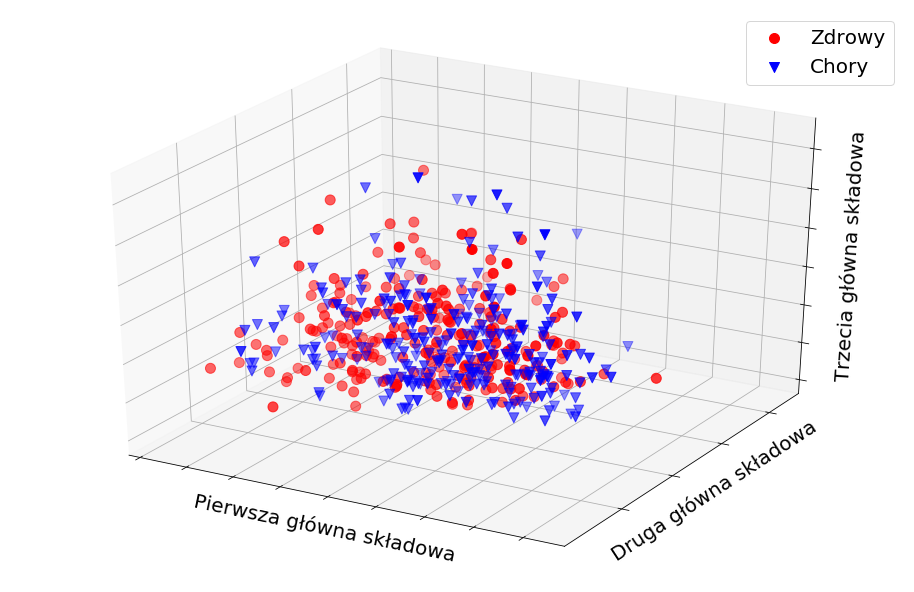

In [146]:
fig = plt.figure()
fig.set_size_inches(16, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[X['Status']=='Zdrowy']['A'],
           X[X['Status']=='Zdrowy']['B'],
           X[X['Status']=='Zdrowy']['C'],
           s=100,
           c='r',
           marker='o',
           label='Zdrowy')
ax.scatter(X[X['Status']=='Chory']['A'],
           X[X['Status']=='Chory']['B'],
           X[X['Status']=='Chory']['C'],
           s=100,
           c='b',
           marker='v',
           label='Chory')
plt.legend(loc='upper right', frameon = True, fontsize=20)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('Pierwsza główna składowa', fontsize=20)
ax.set_ylabel('Druga główna składowa', fontsize=20)
ax.set_zlabel('Trzecia główna składowa', fontsize=20)
plt.show()

# Dummy variables

We'll need to convert categorical features (Status) to dummy variables, because our alghoritm can't understant what means 'healthy'.

In [147]:
status = pd.get_dummies(allpatients['Status'],drop_first=True)

In [148]:
allpatients.drop(['Status'],axis=1,inplace=True)

In [149]:
allpatients['Chory'] = status
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Chory
0,2.264942,-1.416545,0.316645,0.756835,-0.489999,1
1,1.073054,-1.437500,-0.343569,2.560710,0.357747,1
2,0.924651,-0.467857,0.489798,0.320119,0.180116,1
3,-1.348430,1.072796,-1.322592,0.573956,0.930400,1
4,-0.580656,0.179885,-0.820770,1.574585,0.097906,1


# Train test split
Dataset is splitted into train set 75% and test set 25%.

In [150]:
from sklearn.model_selection import train_test_split

In [151]:
X_train, X_test, y_train, y_test = train_test_split(allpatients.drop(['Chory'],axis=1), 
                                                    allpatients['Chory'], 
                                                    test_size=0.25, 
                                                    random_state=42)

### K-fold validation
In order to find best hiper-parameters k-fold validation is used, due to low number of train examples

In [152]:
num_folds = 5

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# Logistic Regression

In [153]:
from sklearn.linear_model import LogisticRegression

In [163]:
accuracies = {}
C = [1e-2, 1e-1, 5e-1, 1, 1.4, 1.8, 2, 2.4, 2.8, 3, 5, 10]

for c in C:
    for i in range(num_folds):
        logModel = LogisticRegression(penalty='l1', C=c, solver='liblinear')
        
        train_set = np.concatenate(X_train_folds[:i]+X_train_folds[i+1:])
        labels_set = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
        
        logModel.fit(train_set, labels_set) 
        
        y_val_pred = logModel.predict(X_train_folds[i])
        val_acc = np.mean(y_val_pred == y_train_folds[i])
        
        if c in accuracies:
            accuracies[c].extend([val_acc])
        else:
            accuracies[c] = [val_acc]

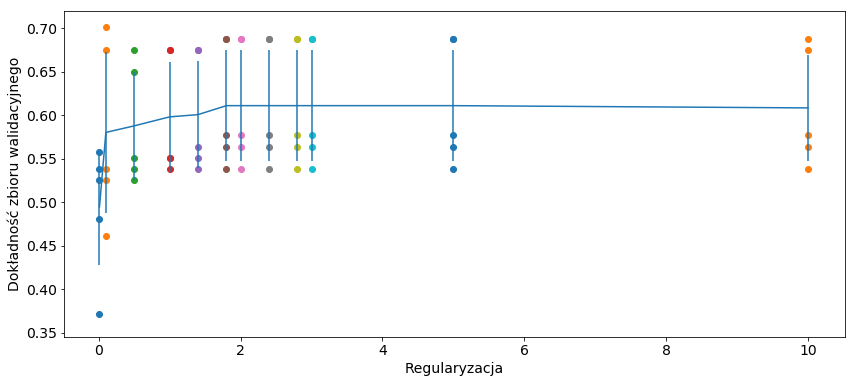

In [164]:
# plot the raw observations

for c in C:
    acc = accuracies[c]
    plt.scatter([c] * len(acc), acc)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracies.items())])
plt.errorbar(C, accuracies_mean, yerr=accuracies_std)
plt.xlabel('Regularyzacja', fontsize=14)
plt.ylabel('Dokładność zbioru walidacyjnego', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [165]:
# Based on the cross-validation results above  I picked optimal C.
# I retrain the classifier using all the training data, and test it on the test
# data.
c = 2
log_model = LogisticRegression(penalty='l1', C=c, solver='liblinear')
log_model.fit(X_train, y_train)
prediction = log_model.predict(X_test)

# Evaluation
Check precission, recall, f1-score using classification report

In [166]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.55      0.61      0.58        67
           1       0.53      0.46      0.49        63

   micro avg       0.54      0.54      0.54       130
   macro avg       0.54      0.54      0.53       130
weighted avg       0.54      0.54      0.54       130



In [167]:
print(confusion_matrix(y_test,prediction))

[[41 26]
 [34 29]]


# Random Forest

In [168]:
from sklearn.ensemble import RandomForestClassifier

In [169]:
accuracies = {}
n_estimators = [10, 50, 100, 120, 140, 160, 180, 200, 250, 300]

for n in n_estimators:
    for i in range(num_folds):
        rf_model = RandomForestClassifier(n_estimators=n)
        
        train_set = np.concatenate(X_train_folds[:i]+X_train_folds[i+1:])
        labels_set = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
        
        rf_model.fit(train_set, labels_set) 
        
        y_val_pred = rf_model.predict(X_train_folds[i])
        val_acc = np.mean(y_val_pred == y_train_folds[i])
        
        if n in accuracies:
            accuracies[n].extend([val_acc])
        else:
            accuracies[n] = [val_acc]

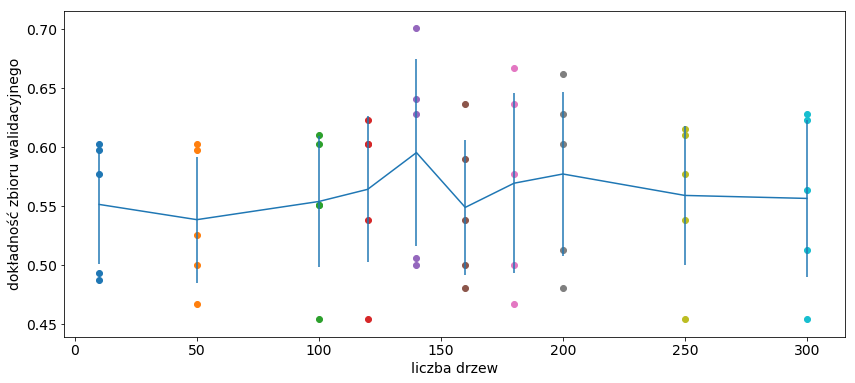

In [170]:
# plot the raw observations

for n in n_estimators:
    acc = accuracies[n]
    plt.scatter([n] * len(acc), acc)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracies.items())])
plt.errorbar(n_estimators, accuracies_mean, yerr=accuracies_std)
plt.xlabel('liczba drzew', fontsize=14)
plt.ylabel('dokładność zbioru walidacyjnego', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [171]:
# Based on the cross-validation results above  I picked optimal number of estimators.
# I retrain the classifier using all the training data, and test it on the test
# data.
best_n = 140
rf_model = RandomForestClassifier(n_estimators=best_n)
rf_model.fit(X_train, y_train)
prediction = rf_model.predict(X_test)

# Evaluation

In [172]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.64      0.52      0.57        67
           1       0.57      0.68      0.62        63

   micro avg       0.60      0.60      0.60       130
   macro avg       0.60      0.60      0.60       130
weighted avg       0.61      0.60      0.60       130



In [173]:
print(confusion_matrix(y_test, prediction))

[[35 32]
 [20 43]]


In [174]:
feature_importance = rf_model.feature_importances_

[Text(0,0,'Maks'),
 Text(0,0,'Min'),
 Text(0,0,'RMS'),
 Text(0,0,'Kurt'),
 Text(0,0,'Skos')]

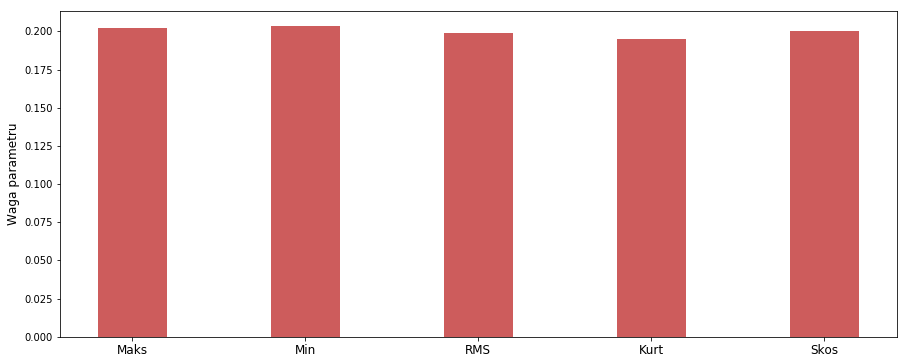

In [175]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
plt.grid(b=False)
ind = np.arange(len(feature_importance))  # the x locations for the groups
width = 0.4  # the width of the bars
ax.bar(ind, feature_importance, width, color='IndianRed')
ax.set_ylabel('Waga parametru', fontsize=12)
ax.set_xticks(ind)
ax.set_xticklabels(['Maks', 'Min', 'RMS', 'Kurt', 'Skos'], fontsize=12)